In [1]:
%matplotlib inline
from __future__ import division, print_function
import pylab as plt
import book_format
book_format.load_style(name='/styles/custom4.css')

# Markov Decision Processes and Dynamic Optimization

So far we have seen a number of approaches for calculating optimal decisions from a set of competing alternative actions. However, making optimal decisions when outcomes or events occur over time is more difficult. This is particularly the case when there is uncertainty in the dynamics of the system. That is, the state transitions from one point in time to the next can be influenced by decisions made at each step.

## Iterative Decision-making

First let's try to characterize the iterative (or sequential) decision-making problem. 

A decision-maker (or **agent**) is required to make recurring decisions. In a natural resource management setting, this could entail the setting of annual harvest policies (bag or catch limits) or stocking decisions; in an epidemiologic setting, this could be deciding the composition of the annual influenza vaccine based on information from outbreaks in other parts of the world.

In principle, sequential decisions may be made in continuous time; for simplicity we will constrain decisions to occur at discrete time steps:

$$t = 0, 1, 2, 3, \ldots$$

the decision intervals may or may not be of fixed widths; they may be arbitrary successive deicision-making stages.

At each time step $t$, the decision-maker receives some representation of the environment’s **state** $x_t$.

$$x_t \in X$$

the state may be univariate or multivariate, and may range from precise low-level instrument readings to high-level categorical descriptors of the environment.

Given this state, the decision-maker chooses an **action** $a_t$ from a set of actions whose composition may depend on the state.

$$a_t \in A(x_t)$$

Actions too can be specific and fine-grained (*e.g.* setting of waterfowl bag limits and season lengths) or be more general, high-level policy decisions (*e.g.* initiate captive breeding program or build a wildlife refuge).
The set of available actions may also be temporally dynamic.

Partly as the result of taking this action, the decision-maker receives a numeric **reward**

$$r_t \in R$$

and the system moves to a **new state** $s_{t+1}$ as the time step increments.


![RL environment](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2015-03-16-08-29-10.png)


#### In general, the goal is to maximize the system reward received, over the long run

The simplest case is the simple sum of rewards:

$$r = r_t + r_{t+1} + \ldots + r_{T}$$

where $T$ is a final time step. This approach makes sense in applications in which there is a natural notion of final time step, that is, systems which are *episodic*. There may be just a single episode, or multiple episodes.

In contrast, some problems entail a continual process-control task (or episodes that are so long that they may be considered so). We call these *continuing* tasks. This implies that $T=\infty$, and the corresponding sum of rewards could itself easily be infinite.

In continuing tasks (and even some episodic tasks), we must invoke a **discount rate** $\gamma \in [0, 1]$ which determines the present value of future rewards. The rate applies multiplicatively to future rewards:

$$r = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}$$

The notion is that a reward received $k$ time steps in the future is worth only $\gamma^{k-1}$ times what it would be worth if it were received immediately. If $\gamma < 1$, the infinite sum $r$ has a finite value. 

Smaller values of $\gamma$ result in *myopic* behavior; In the special case where $\gamma = 0$, the decision-maker is concerned only with maximizing current reward.

Here's an example of reward discounting using simulated data. We are simulating 20 time steps (years?) of expected returns from a Poisson distribution with mean 100. The total reward is just the sum of the individual rewards at each time step.

Total reward is 1999


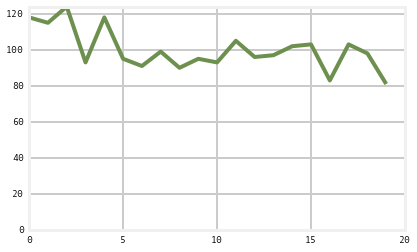

In [2]:
%matplotlib inline
import pylab as pl
import numpy as np

reward = np.random.poisson(100, 20)
pl.plot(reward); pl.ylim(0, max(reward))
print("Total reward is", reward.sum())

Applying a discount rate to this reduces the value of the future returns relative to returns at time 0.

Total discounted reward is 914.409263811


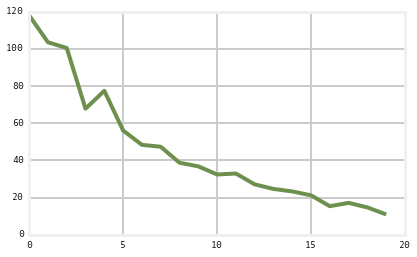

In [3]:
gamma = 0.9

discounted_reward = [r*gamma**i for i,r in enumerate(reward)]
pl.plot(discounted_reward)
print("Total discounted reward is", sum(discounted_reward))

## The Markovian Property

It can be useful to model these problems as a discrete time Markov process. Markov processes have the property that the future depends on the current state, but not past states. In other words, the transitions are *conditionally independent* of past states, given the present state.

$$\begin{gathered}
\begin{split}Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

This is the Markovian property.

A **discrete** Markov process is one where the state space is *countable*. It describes movement from state $i$ to state $j$ over some interval of time $\Delta t$.

$$p(X_{t + \Delta t} = j | X_t = i)$$

It is useful to think of the Markovian property as “mild non-independence”.

## Markov Chains

A Markov chain is a special type of discrete Markov process, where the time step $\Delta t=1$ and the transitions are stationary. Stationarity implies that the transition probabilities are time-homogeneous.

$$p_{ij} = p(X_{t + 1} = j | X_t = i)$$

> **Homogeneity**: A Markov chain is homogeneous at step t if the transition probabilities are independent of time t.

> **Stationarity**: A stationary Markov chain produces the same marginal distribution when multiplied by the transition kernel.

The Markov chain wanders about the state space, remembering only where it has just been in the last time step. The collection of transition probabilities is sometimes called a *transition matrix* when dealing with discrete states, or more generally, a *transition kernel*.

$$P = \left[{
\begin{array}{c}
  {p_{11}} & {p_{12}} & \ldots & {p_{1k}}  \\
  {p_{21}} & {p_{22}} & \ldots & {p_{2k}}  \\
  \vdots & \vdots & \ddots & \vdots \\
  {p_{k1}} & {p_{k2}} & \ldots & {p_{kk}}  \\
\end{array}
}\right]$$

Row $i$ of the matrix are the probabilities of moving from state $i$ to each possible state $j$ (including $i$ itself); hence the rows sum to 1.

### Example: stationary Markov chain

Consider a Markov transition matrix

$$P = \left[{
\begin{array}{c}
  {0.3} & {0.5} & {0.2}  \\
  {0.6} & {0} & {0.4}  \\
  {0} & {0.4} & {0.6}  \\
\end{array}
}\right]$$

The three states in the space are all recurrent aperiodic, and therefore it has a stationary limiting distribution. We can show this by simulating the chain with an arbitrarily-chosen starting distribution.

In [4]:
P = np.array([[0.3, 0.5, 0.2],
              [0.6, 0., 0.4],
              [0., 0.4, 0.6]])

x = [0.5, 0.3, 0.2]

In Python, using the NumPy library, we can manipulate arrays and matrices using linear algebra. For example, the method `T` will transpose a matrix, and the method `dot` will take the dot product (*i.e.* matrix multiplication) with another array. We will use these methods to transition the state vector `x` into a new state.

Here is the state vector after a single transition:

In [5]:
P.T.dot(x)

array([ 0.33,  0.33,  0.34])

Two transitions:

In [6]:
P.T.dot(P.T.dot(x))

array([ 0.297,  0.301,  0.402])

Five transitions:

In [7]:
for t in range(5):
    x = P.T.dot(x)

x

array([ 0.261897,  0.305349,  0.432754])

Fifteen transitions:

In [8]:
for t in range(10):
    x = P.T.dot(x)

x

array([ 0.26086929,  0.30434832,  0.43478239])

You can see that the vector stops changing--becomes *stationary*--after about 5 iterations.

If a Markov chain is stationary, we can express two-step (or more) transitions in terms of its constituent one-step transitions. The probability of moving from $i$ to $k$ in two steps is just the product of the probability moving from $i$ to $j$ in one step, and then from $j$ to $k$ in another step, summing over all $j$.

$$ p(X_{t+2} = k | X_t = i) = p_{ik}^{(2)} = \sum_{j=1}^{n_j} p_{ij} p_{jk}$$

This generalizes to an arbitrary number of steps by:

$$p_{ik}^{(r+s)} = \sum_{j=1}^{n_j} p_{ij}^{(r)} p_{jk}^{(s)}$$

which describes the probability of moving from $i$ to $j$ in $r$ steps, and then from $j$ to $k$ in $s$ steps. This relationship is known as the *Chapman-Kolmogorov* equation.

### Example: Disease dynamics

One can simulate the dynamics of an infectious disease using a discrete Markov process. This example is from Zipkin et al. (2010), which examined an avian disease affecting house ﬁnch (*Carpodacus mexicanus*) populations. The *Mycoplasma gallisepticum* pathogen caused a major epidemic of conjunctivitis in house ﬁnches in 1994, and was modeled by Zipkin et al.

In [9]:
P = np.array([[0.90, 0.05, 0.05],
                [0.10, 0.70, 0.20],
                [0, 0, 1]])
P

array([[ 0.9 ,  0.05,  0.05],
       [ 0.1 ,  0.7 ,  0.2 ],
       [ 0.  ,  0.  ,  1.  ]])

The rows are the state of a process for a given individual (0 = susceptible, 1 = infected and 2 = dead) at time $t$ and the columns indicate the state of the process at the following time step $t + 1$.

Let's use this transition matrix to simulate the disease dynamics of a population of 100 susceptible individuals.

In [10]:
x = [100, 0, 0]

For each step in the process, the transition matrix will be multiplied by the current vector of states, to yield an updated vector of states.

In [11]:
# Initialize list with initial states
X = [x]

for t in range(20):
    # Calculate transistion
    new_x = P.T.dot(X[-1])
    # Append new vector to list
    X.append(new_x)

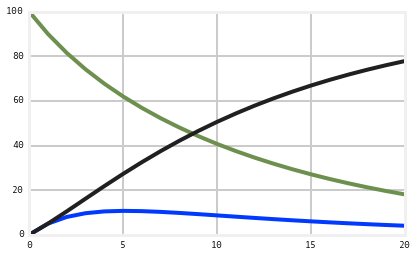

In [12]:
pl.plot(X)

The Markov assumption greatly simplifies the sequential decision analysis problem. If we had to model the process generally, we would be specifying:

$$Pr(r_{t+1}, s_{t+1} | r_t, s_t, a_t, r_{t-1}, s_{t-1}, a_{t-1}, \ldots, r_0, s_0, a_0)$$

If we are able to assume conditional independence, then we can drop much of this, so the model becomes:

$$Pr(r_{t+1}, s_{t+1} | r_t, s_t, a_t)$$

By iterating this equation, one can predict all future states and expected rewards from knowledge only of the current state just as well as if one had the complete history up to the current time.

## Markov Decision Process

A Markov process where the transition probabilities can be influence by the actions of a decision-maker is called a Markov decision process.

A Markov decision process (MDP) is defined by the available states and alternative actions, as described above, as well as by the state dynamics inherent to the environment.

Given any state and action, $x$ and $a$, the probability of each possible next state, $x^{\prime}$, is described by the **state dynamics function**:

$$f(x^{\prime} | x, a) = Pr(X_{t+1}=x^{\prime} | X_t=x, A_t=a)$$

These probabilities correspond to the elements in the transmission matrix, as described in the Markov chain discussion.

For any current state and action, $x$ and $a$, together with any next state, $x^{\prime}$, the expected value of the next reward is:

$$r(x, a, x^{\prime}) = E[R_{t+1} | X_t=x, A_t=a, X_{t+1}=x^{\prime}]$$



![MDP](http://fonnesbeck-dropshare.s3.amazonaws.com/MDP_flow.png)


In some real-world problems, the actual system state is not entirely known by the decision maker, rendering the states only partially observable. Such MDPs are known as **partially-observable Markov decision processes** (POMDP).

The sequence of the decision rules to be used at each decision point can be summarized as a **policy**, which is a function that maps states to actions:

$$\pi_t : X_t \mapsto A_t$$

If the policy is stationary, then that $\pi_t = \pi$ (*i.e.* the policy does not change over time)

We can denote the influence of a policy on the Markov transitions by:

$$p_{\pi}(X_{t+1} = j | X_t = i)$$

Which implies that the state-specific decision at each step is taken from $\pi$.


## Value functions

We can compare competing MDP policies by evaluating their performance in terms of value. A **value function** is a function of the system state that is an estimate of how good it is to be in that state. This value is in terms of *expected future rewards*. Since the expected future rewards, as shown above, are a function of the state-specific actions taken at each decision step, we can use the value function to discriminate among different policies that may be used to selection actions.

The value of state $x$ under policy $\pi$ is the total expected (discounted) system reward for starting in state $x$, and following policy $\pi$ thereafter.

$$V_{\pi}(x) = E_{\pi}[R | X_t=x] = E_{\pi} \left[ \sum_{k=0}^{\infty} \gamma^k r_{t+k+1} \big| X_t=x \right]$$

this is the state-value function for policy $\pi$.

Note that in some applications, the value function is in terms of state-action pairs, thereby describing how good it is to perform a particular action from a particular state, following policy $\pi$ thereafter.

$$Q_{\pi}(x, a) = E_{\pi}[R | X_t=x, A_t=a] = E_{\pi} \left[ \sum_{k=0}^{\infty} \gamma^k r_{t+k+1} \big| X_t=x, A_t=a \right]$$

Note that the value function can be written recursively:

$$\begin{aligned}V_{\pi}(x) &= E_{\pi}[R | X_t=x] \\
&= E_{\pi} \left[ \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \big| X_t=x \right] \\
&= E_{\pi} \left[ R_{t+1} + \gamma \sum_{k=0}^{\infty} \gamma^k R_{t+k+2} \big| X_t=x \right] \\
&= \sum_{x^{\prime}} f(x^{\prime} | x, a) \left[ r(x, a, x^{\prime}) + \gamma E_{\pi} \left[ \sum_{k=0}^{\infty} \gamma^k R_{t+k+2} \big| X_t=x \right] \right] \\
&= \sum_{x^{\prime}} f(x^{\prime} | x, a) \big[ r(x, a, x^{\prime}) + \gamma  \color{red}{V_{\pi}(x^{\prime})} \big]
\end{aligned}$$

This expression is the **Bellman equation** for $V_{\pi}$. The Bellman equation averages over all the candidate next states $x^{\prime} \in X$, weighting each by its probability of occurring as specified by the state dynamics function. 

It states that the value of the start state must equal the (discounted) value of the expected next state, plus the reward expected along the way.

## Optimizing MDPs

In order to solve our decision analysis problem, we have to identify a policy that maximizes the long-run expected rewards. We now have a way to achieve this: *optimize Bellman's equation*.

An optimal policy $\pi^*$ maximizes $V_{\pi}(x)$ for all $x \in X$. The value function under this policy is the optimal value function:

$$V^*(x) = \max_{\pi}V_{\pi^*}(x)$$

Bellman's equation allows us to approach the optimization problem into smaller, recursive sub-problems. In fact, Bellman's **Principle of Optimality** states this explicitly:

> An optimal policy has the property that whatever the intial state and initial decision are, the remaining decisions must constitute an optimal policy with regard to the state resulting from the first decision.

The Bellman's optimality equation expresses the fact that the value of a state under an optimal policy must equal the expected return for the best action:

$$V^*(x) = \max_{a \in A(s)} \sum_{x^{\prime}} f(x^{\prime} | x, a) \big[ r(x, a, x^{\prime}) + \gamma  V^*(x^{\prime}) \big]$$

By means of $V^*(x)$, the optimal expected long-term return is turned into a quantity that is locally and immediately available for each state.

The business of optimizing MDPs is therefore a matter of calculating or estimating $V^*(x)$.

## Dynamic Programming

Dynamic programming is an approach to computing optimal policies for MDPs, provided that an appropriate state dynamics model is available. These methods use value functions to organize and structure the search for good policies. Specifically, they turn Bellman's equations into assignments, using them to update approximations to the true value function.

There are 2 fundamental DP algorithms to solve infinite-horizon discounted MDPs: 

1. value iteration 
2. policy iteration  

Value iteration starts with an arbitrary value for each state and, at each iteration, solves Bellman's equation using the value from the previous iteration until the difference between successive values becomes sufficiently small.

It starts with an **arbitrary decision rule** and finds its value; if an improvement in the current decision rule is possible, using the current value function estimate, then the algorithm will find it; otherwise, the algorithm will stop, yielding the optimal decision rule.

In many situations, the stationary assumption is not reasonable, such as when the transition probability represents the probability of a disease outcome that is increasing over time or when age-dependent mortality is involved.

### Policy Iteration

The expected value expression of $V^*(x)$ is a system of equations, whose solution is straightforward, though requiring extensive computation. Instead, an iterative approach can be adopted.

An initial approximation (guess) $V_0$ is chosen, and the Bellman optimality equation is used to updte $V_0$:

$$V_{k+1}(x) = \sum_a \pi(a|x) \sum_{x^{\prime}} f(x^{\prime} | x, a) \big[ r(x, a, x^{\prime}) + \gamma  V_{k}(x^{\prime}) \big]$$

where $\pi(a|x)$ is the probability of selecting action $a$ under policy $\pi$ in state $x$. This algorithm is called iterative policy evaluation, and the sequence $\{V_k\}$ can be shown in general to converge to $V_{\pi}$ as $k \rightarrow \infty$.

To produce each successive approximation, $V_{k+1}$ from $V_k$, iterative policy evaluation applies the same operation to each state: it replaces the old value of $x$ with a new value obtained from the old values of the successor states of $x$, and the expected immediate rewards, along all the one-step transitions possible under the policy being evaluated. This operation is called a **full backup**.

All the backups done in DP algorithms are called full backups because they are based on *all possible next states* rather than on a sample next state. 

![policy evaluation](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2015-03-17-08-47-04.png)

This is known as **policy evaluation**. Each iteration involves a sweep through the state space, and terminates when the largest change is smaller than the stated tolerance.

Now that we are able to evaluate the policy, we can attempt to **improve** it.

Suppose we have determined the value function $V_{\pi}$ for some deterministic policy $\pi$ (not necessarily optimal!). For some state $x$, we might wonder whether we should deviate from $\pi$ to deterministically choose an action $a \ne \pi(x)$. From policy evaluation, we know the value of following the current policy from $x$, but would it be better or worse to change to the new policy?

The value of the new policy is:

$$\begin{aligned}
Q_{\pi}(x, a) &= E_{\pi}\left[R_{t+1} + \gamma V_{\pi}(X_{t+1}) \big| X_t=x, A_t=a \right] \\
&= \sum_{x^{\prime}} f(x^{\prime} | x, a) \big[ r(x, a, x^{\prime}) + \gamma  V_{\pi}(x^{\prime}) \big]
\end{aligned}$$

notice we are using the state-action pair formulation of the value function here. If we take the action that maximizes this, we should replace the action in $\pi$ with the maximal action, to derive a new policy $\pi^{\prime}$.

$$\begin{aligned}
\pi^{\prime}(x) &= \text{argmax}_a Q_{\pi} (x, a) \\
&= \text{argmax}_a E_{\pi}\left[R_{t+1} + \gamma V_{\pi}(X_{t+1}) \big| X_t=x, A_t=a \right] \\
&= \text{argmax}_a \sum_{x^{\prime}} f(x^{\prime} | x, a) \big[ r(x, a, x^{\prime}) + \gamma  V_{\pi}(x^{\prime}) \big]
\end{aligned}$$

The process of making a new policy that improves on an original policy, by making it greedy with respect to the value function of the original policy, is called **policy improvement**.

Once a policy has been improved to yield a better policy, we can then compute $V_{\pi^{\prime}}$ and improve it again to yield an even better $\pi^{\prime\prime}$. We can thus obtain a sequence of monotonically improving policies and value functions:

$$\pi_0 \xrightarrow{evaluate} V_{\pi_0} \xrightarrow{improve} \pi_1 \xrightarrow{evaluate} V_{\pi_1} \xrightarrow{improve} \dots \xrightarrow{improve} \pi^* \xrightarrow{evaluate} V_{\pi^*}$$ 


![policy iteration](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2015-03-17-11-51-14.png)

Note that each policy evaluation, itself an iterative computation over all the states, is started with the value function from the previous policy. This typically results in quicker convergence of policy evaluation, since there should generally be few changes to the value function from one policy to the next.

### Value Iteration

A drawback of policy iteration is that the policy evaluation component can be computationally intensive, involving multiple sweeps through the state space. It turns out that it is usually not necessary to run the policy evaluation to convergence in order to obtain the optimial policy; in most cases, the policy will become stationary before the policy evaluation converges.

The **value iteration** algorithm is a simplified operation that combines policy improvement and (truncated) policy evaluation into a single step.

$$\begin{aligned}
V_{k+1}(x) &= \max_a E\left[R_{t+1} + \gamma V_k(X_{t+1}) \big| X_t=x, A_t=a \right] \\
&= \max_a \sum_{x^{\prime}} f(x^{\prime} | x, a) \big[ r(x, a, x^{\prime}) + \gamma  V_k(x^{\prime}) \big]
\end{aligned}$$

It can be shown that $V_k(x)$ converges to $v^∗(x)$ under the same conditions that guarantee the existence of $v^∗(x)$.

Notice that value iteration backup is identical to the policy evaluation backup, except that it requires the maximum to be taken over all actions. In fact, it is just the Bellman optimality equation, turned into an update rule.

![value iteration](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2015-03-17-14-59-20.png)

### Example: Optimal taxi behavior

Consider a simple, contrived example of a taxi driver attempting to maximize fares. The taxi serves two adjacent towns: A and B. Each time the taxi discharges a passenger, the driver must can choose from two possible actions:

1. **Cruise** the streets looking for a passenger.
2. Go to the nearest taxi **stand** (hotel, train station, etc.)

Passengers picked up while cruising tend to stay in the same city, while those from the taxi stand have  higher probability of moving to the other city. 

City B pays higher fares, than city A.

Cruising fares are higher than standing fares in city A, while the opposite is true in city B.

*What is the optimal behavior in each state?*

In [13]:
# States
A, B = 0, 1
CRUISE, STAND = 0, 1

# State transitions
T = {CRUISE: {
    A: {A: 0.9, B: 0.1}, 
    B: {A: 0.1, B: 0.9}
},
    STAND: {
    A: {A: 0.4, B: 0.6}, 
    B: {A: 0.6, B: 0.4}
}}

# Rewards
R = {
    CRUISE: {A: 8, B: 20}, 
    STAND: {A: 5, B: 22}
}


In [14]:
states = [A, B]
actions = [CRUISE, STAND]

Next, we need to intitialize the data structures for storing values, indexed by states and actions:

In [15]:
V = {}
V2 = {}
logs = {}

for s in states:
    logs[s] = {}
    for a in actions:
        logs[s][a] = []
             
for s in states:
    V[s] = 0
    V2[s] = 0

Model parameters, including tolerance for convergence and the desired discount rate:

In [16]:
# Convergence criterion
epsilon = 0.0001
# Discount rate
gamma = 0.8
# Maximum number of iterations
max_iters = 100

In [17]:
for iteration in range(max_iters):
    for s in states:
        
        value_candidates = []
        for a in actions:
            value = R[a][s] + gamma * sum(T[a][s][s2]*V[s2] for s2 in states)
            value_candidates.append(value)
            logs[s][a].append(value)
            
        # Choose the largest candidate value
        V2[s] =max(value_candidates)
        
    # If there is no change from the last estimate, we are done
    if max(abs(V2[s] - V[s]) for s in states) < epsilon:
        break
    else:
        V, V2 = V2, {}
        
print("Iterations: %i" % len(logs[A][STAND]))

Iterations: 56


In [18]:
for s in states:
    for a in actions:
        value = R[a][s] + gamma * sum(T[a][s][s2]*V[s2] for s2 in states)
        print("State: %s Action: %s --> %f" % (['A', 'B'][s], ['CRUISE', 'STAND'][a], value))

State: A Action: CRUISE --> 67.473360
State: A Action: STAND --> 72.368097
State: B Action: CRUISE --> 92.104939
State: B Action: STAND --> 86.210202


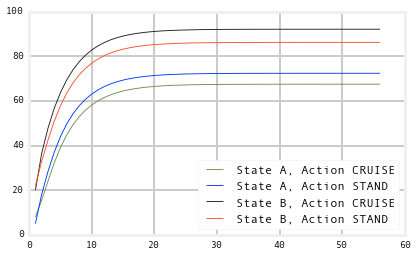

In [19]:
%matplotlib inline
import pylab as pl

x_axis = range(1, 1 + len(logs[A][STAND]))
for s in states:
    for a in actions:
        pl.plot(x_axis, logs[s][a], label="State %s, Action %s" % (['A', 'B'][s], ['CRUISE', 'STAND'][a]), 
                linewidth=0.9)
pl.legend(loc=4)

## Backward Induction

We can also calculate optimal policies by applying the backward induction algorithm. It is an iterative procedure, but unlike value or policy iteration, it iterates over time. Specifically, it iterates backward in time, beginning at the time horizon $T$ which is populated with a terminal value function (or arbitrarily set to zero). It then calculates the immediate reward from the previous time step, recording the action that leads to the highest expected total value. The value for each state under the optimal policy is stored, and updated repeatedly according to this algorithm.

This backward recursion approach reduces computational complexity by only tracking the value function corresponding to the optimial policy.

Initialize the optimal value fuction (lookup table) 

$$v^*_{t+1}(x_{t+1}) = v_T(x_T)$$

For each value of $x_t$, $a_t$, $z_t$ compute the next state:

$$x_{t+1} = f_t(x_t, a_t, z_t)$$

along with the associated probability 

$$Pr[x_{t+1} = f_t(x_t a_t, z_t)] = p(z_t | x_t, a_t)$$

Compute the optimal value function for the current time step

$$V_t^*(x_t) = \max_{a_t \in A_t} \left[ \sum_{z_t \in Z_t} p(z_t|a_t,z_t)[v^*_{t+1}(x_{t+1}) + r_t(x_t, x_{t+1},a_t,z_t)]\right] $$ 

However, we cannot evaluate $v^*_{t+1}(x\_{t+1})$ directly, since it is a function of discrete values of $x_t$. Thus, an interpolation must be performed:

$$v^*_{t+1}(x_{t+1}) = L(v^*_{t+1}(X_{t+1}), x_{t+1})$$

where $L$ is the linear interpolation function.

We then substitute the state dynamics function into the value function, so that it is expressed in terms of values at time $t$:

$$V_t^*(x_t) = \max_{a_t \in A_t} \left[ \sum_{z_t \in Z_t} p(z_t|a_t,z_t)[L(v^*_{t+1}(X\_{t+1}), \color{red}{f_t(x_t, a_t, z_t)}) + r_t(x_t, x_{t+1},a_t,z_t)]\right] $$ 




### Mangel and Clark example

Marc Mangel and Colin Clark applied stochastic dynamic programming to address behavioral ecology problems. In this case, the "decision-maker" is an individual organism that presumably is optimizing some measure of biological fitness in the face of various constraints and tradeoffs.

Consider a simple patch dynamics model: an organism has three patches available to it. Two patches are feeding patches, and a third is a reproductive patch, where it can lay eggs. In the feeding patches, the food resources are used to enhance both survival and reproduction. At the end of the season, the organism may reproduce prior to dying, according to: 

$$\Phi(x, T) = \frac{Ax}{x + x_0}$$

where $A$ and $x_0$ are parameters. This is the *future expected fitness* function.

Each of the three patches has different costs and risks. There is an energetic cost $a_i$, a mortality risk $m_i$, a feeding probability $p_i$, and an energetic value of food $y_i$ for each patch:

In [20]:
import pandas as pd

m = [.01, .05, .02]
p = [.2, .5, 0]
y = [2, 4, 0]
a = [1, 1, 1]

pd.DataFrame({'m': m, 'p': p, 'y':y, 'a':a}, index=(1,2,3))

,a,m,p,y
1,1,0.01,0.2,2
2,1,0.05,0.5,4
3,1,0.02,0.0,0


Thus, the decision is whether to occupy patch 1, 2 or 3.

The value is calculated as the reproductive success for behaviour $n$ at energy $x$, time $t$ in the fitness array $f$.

In [21]:
# Largest energy store
xmax = 30
# Minimum reproductive energy
xrep = 4
# Time horizon
tmax = 20

c = 4
A = 60.0
x0 = 0.25*xmax
xint = 2

Based on these parameters, the future reproductive function is:

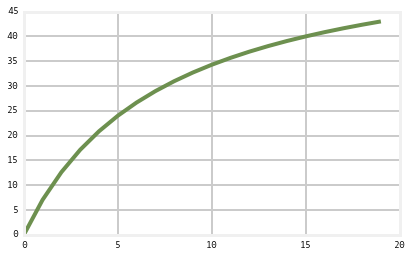

In [22]:
Phi = lambda x: A*x/(x + x0)

pl.plot(np.arange(20), Phi(np.arange(20)))

Next, we specify the **state-action value function**, which here is the value of visiting patch $i$ on day $t$, given energetic stores $x$.

The state dynamics are specified by:

$$X(t+1) = \left\{ \begin{array}{l}
x - a_i + Y_i, &\text{with probability } p_i \\
x - a_i, &\text{with probability } 1 - p_i
\end{array} \right.$$

which describes the probability of locating food during day $t$ in patch $i$. Each of these have associated fitness values:

$$Q_i(x, t) = \left\{ \begin{array}{l}
(1 - m_i)F(x - a_i + Y_i, t+1), &\text{with probability } p_i \\
(1 - m_i)F(x - a_i, t+1) &\text{with probability } 1 - p_i
\end{array} \right.$$

for patches 1 and 2. Visits to the reproductive patch involves three alternative scenarios, depending on the state:

- If energetic reserves are below the reproductive minimum $x_{rep}$, there is no reproduction, and the only fitness is from future expected reproduction:

$$Q_3(x,t) = (1 - m_3)F(x - a_3, t+1)$$

- If energetic reserves are just above the reproductive minimum, within the daily energetic cost, there is limited reproduction:

$$Q_3(x,t) = (x - x_{rep}) + (1 - m_3)F(x - a_3, t+1)$$

- If energetic reserves are above $x_{rep} + c$, there is full reproduction:

$$Q_3(x,t) = c + (1 - m_3)F(x - c- a_3, t+1)$$

In [23]:
def Q(i,x,t,f):

    # Fitness value for visiting the two foraging patches
    if i<2:
        
        # forages
        x1 = chop( x + y[i] - a[i], 0, xmax ) 
        x2 = chop( x - a[i], 0, xmax )
        
        return (1.0 - m[i]) * (p[i] * f[x1,t+1] + (1.0 - p[i]) * f[x2,t+1])
    
    else:
        
        # tries to reproduce
        if x < xrep: # can't reproduce
            reproduction = 0
            x1 = chop(x - a[i],0,xmax)
            
        elif x < xrep+c: # limited reproduction
            reproduction = x - xrep
            x1 = chop(xrep - a[i], 0, xmax)
            
        else: # full reproduction
            reproduction = c;
            x1 = chop(x - a[i] - c, 0, xmax)
            
        return reproduction + (1.0 - m[i]) * f[x1,t+1]
    
def chop(x, minval, maxval):
    # Utility function to constrain state to the range [minval, maxval]

    if minval <= x <= maxval:
        return x
    elif x<minval:
        return minval
    else:
        return maxval

At each step in the DP, we caluclate the optimal decision and the corresponding value

In [24]:
listmax = lambda x: (np.max(x), np.argmax(x))

def update(f, dec, t):
    
    f[0,t] = 0.0
    for x in range(1,xmax+1):
        choices = [];
        for n in range(3):
            choices.append( Q(n,x,t,f) )
            
        (f[x,t], dec[x,t]) = listmax(choices)
        
    return f, dec

Initialize data structures to hold fitness values an decisions

In [25]:
f = np.zeros((xmax+1,tmax+1), float)
dec = np.zeros((xmax+1,tmax+1), int)
for x in range(xmax+1):
    f[x,tmax] = Phi(x)

Run the SDP 

In [26]:
output = []

# Reverse iterate over time
for t in range(tmax-1, 0, -1):
    
    f, dec = update(f, dec, t)
    
    # Scan across states
    for x in range(1, xmax+1):
        output.append(( x, dec[x,t]+1, f[x,t], t ))

In [27]:
output = pd.DataFrame(output, columns=['x', 'dec', 'f', 't'])

Plot the optimal strategy

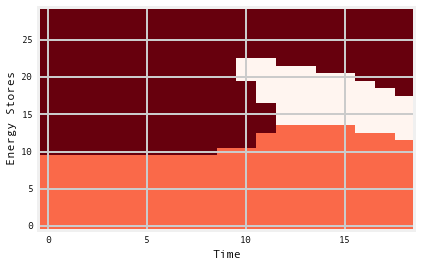

In [28]:
pl.imshow(output.pivot(index='x', columns='t', values='dec'), 
          aspect='auto', cmap='Reds', interpolation='nearest', origin='lower', vmin=1, vmax=3)
pl.ylabel('Energy Stores'); pl.xlabel('Time');

### Exercises

Try experimenting with the model in the following ways:

1. Increase the mortality rate in patch 1 to $m_1=0.05$
2. Set the reproductive payoff in patch 3 to $c=0$.
3. Set the future reproduction parameter $A$ to zero.
4. Attribute a fitness increment only if the organism survives the period in the reproductive patch:

         (1.0 - m[i]) *(reproduction + f[x1,t+1])

## Dynamic Optimization with PyMDPToolbox

We will apply dynamic optimization methods implemented in **PyMDPtoolbox**, a Markov decison process (MDP) toolbox for Python. The MDP toolbox provides classes and functions for the resolution of descrete-time Markov Decision Processes. The list of algorithms that have been implemented includes backwards induction, linear programming, policy iteration, q-learning and value iteration along with several variations.

The classes and functions were developped based on the MATLAB MDP toolbox by the Biometry and Artificial Intelligence Unit of INRA Toulouse (France). There are editions available for MATLAB, GNU Octave, Scilab and R.

Features include:

- Eight MDP algorithms implemented
- Fast array manipulation using NumPy
- Full sparse matrix support using SciPy's sparse package
- Optional linear programming support using cvxopt

### Case Study: Optimal fire management of a threatened species

An early application of these methods to wildlife biology was by Possingham and Tuck (1997), which examines the problem of deriving an optimal fire managment strategy for the conservation of endangered vertebrates.

The Possingham and Tuck model models the spatial structure of the populations in question, but for simplicity, we will simplify the model to a single patch here.

First, we need to specify the dimensions of the problem. In the Possingham and Tuck problem, there are seven population abundance classes (`pop_classes`), including exctinction (0), there are 13 fire classes (`fire_classes`), which represent the number of years since the last burn. The system state is made up of all pairwise combinations of population and fire classes. Since there is no population structure in this problem, there are only two possible actions, `burn` or `no_burn`.

In [29]:
n_pop_classes = 7
n_fire_classes = 13

states = [(p, f) for p in range(n_pop_classes) for f in range(n_fire_classes)]
n_states = len(states)

no_burn, burn = 0, 1

### Input validation

The key to reliable scientific computing is to write tests for all the important steps in your program. To facilitate this, we need test functions to validate the inputs to various functions that we will define. We’re going to want to send the action, population class, fire class, and a probability as input to multiple functions. Each of these functions will raise an exception for invalid entries, and let us know what was passed to the function, versus what was expected.

In [30]:
def check_action(x):
    """Check that the action is in the valid range."""
    if not x in [0,1]:
        msg = "Invalid action '%i', it should be in {0, 1}." % x
        raise ValueError(msg)

def check_population_class(x):
    """Check that the population abundance class is in the valid range."""
    if not (0 <= x < n_pop_classes):
        msg = "Invalid population class '%i', it should be in {0, 1, …, %d}." \
              % (x, n_pop_classes - 1)
        raise ValueError(msg)

def check_fire_class(x):
    """Check that the time in years since last fire is in the valid range."""
    if not (0 <= x < n_fire_classes):
        msg = "Invalid fire class '%i', it should be in {0, 1, …, %d}." % \
              (x, n_fire_classes - 1)
        raise ValueError(msg)

def check_probability(x, name="probability"):
    """Check that a probability is between 0 and 1."""
    if not (0 <= x <= 1):
        msg = "Invalid %s '%i', it must be in [0, 1]." % (name, x)
        raise ValueError(msg)
        
def check_states(x):
    if not (0 <= x < n_states):
        msg = "Invalid index '%i', it should be in {0, 1, …, %d}." % (x, STATES - 1)
        raise ValueError(msg)


### Habitat suitability

The core of our habitat model is a simple relationship between habitat suitability and the number of years since the last fire.

In [31]:
def get_habitat_suitability(years):
    """The habitat suitability of a patch relatve to the time since last fire.

    The habitat quality is low immediately after a fire, rises rapidly until
    five years after a fire, and declines once the habitat is mature. See
    Figure 2 in Possingham and Tuck (1997) for more details.

    Parameters
    ----------
    years : int
        The time in years since last fire.

    Returns
    -------
    r : float
        The habitat suitability.

    """
    if years < 0:
        msg = "Invalid years '%s', it should be positive." % str(years)
        raise ValueError(msg)
    if years <= 5:
        return 0.2*years
    elif years <= 10:
        return -0.1*years + 1.5
    else:
        return 0.5

We can see the form of this relationship by passing a range of values to `get_habitat_suitability`

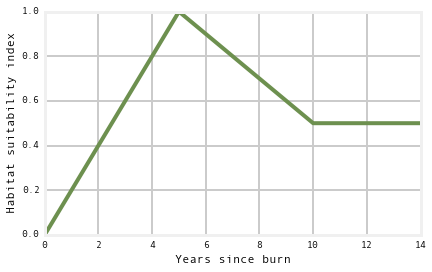

In [32]:
t = range(15)
pl.plot(list(t), [get_habitat_suitability(ti) for ti in t])
pl.xlabel('Years since burn')
pl.ylabel('Habitat suitability index');

### System states

Recall from the discussion of state transition matrices that we can project a state vector into the next state by multiplying it by a matrix of transition probabilities. Each row in the matrix represents a state that the system can start in, while the columns represent the states that the system can transition to. `PyMDPtoolbox` handles state transitions exactly in this way, by matrix multiplication. We will specify one transition probability matrix for each action, `no_burn` and `burn`. PyMDPtoolbox expects a NumPy array as the data structure, since it has fast, built-in methods for performing linear algebra operations.

### Reward function

Here, the reward function returns a chosen measure of habitat quality. Depending on the implementation of the MDP, a reward function can be in terms of just the state, or as a function of state-action pairs. For this example, we only need to specify reward as a function of state. The reward is simple: where the population is still extant, the state recieves a one, otherwise it is zero.

### State space representation

Functionally, each state is uniquely identified by an index into the transition probability matrix, but in the real world, we think of the state as a tuple containing the population abundance class and the number of years since the last fire. Therefore we need functions to crosswalk between these two representations.

In [33]:
def state_to_index(population, fire):
    """Convert state parameters to transition probability matrix index.

    Parameters
    ----------
    population : int
        The population abundance class of the threatened species.
    fire : int
        The time in years since last fire.

    Returns
    -------
    index : int
        The index into the transition probability matrix that corresponds to
        the state parameters.

    """
    check_population_class(population)
    check_fire_class(fire)
    return population*n_fire_classes + fire

In [34]:
state_to_index(3, 4)

43

In [35]:
def index_to_state(index):
    """Convert transition probability matrix index to state parameters.

    Parameters
    ----------
    index : int
        The index into the transition probability matrix that corresponds to
        the state parameters.

    Returns
    -------
    population, fire : tuple of int
        ``population``, the population abundance class of the threatened
        species. ``fire``, the time in years since last fire.

    """
    if not (0 <= index < n_states):
        msg = "Invalid index '%i', it should be in {0, 1, …, %d}." % (index, n_states - 1)
        raise ValueError(msg)
    population = index // n_fire_classes
    fire = index % n_fire_classes
    return (population, fire)

In [36]:
index_to_state(43)

(3, 4)

### State transitions

The dynamics of the transition probabilities are given in Section 2.1 and Figure 1 of Possingham and Tuck (1997):

![figure 1](http://fonnesbeck-dropshare.s3.amazonaws.com/Screen-Shot-2015-03-15-16-25-39.png)

We define:

- $s$: the *state-independent* probability of staying in the **same state**

- $r_F$: the probability the **population increases** one state, given that it does not stay in the same state, and given that it has been $F$ years since the last fire

Transition probabilities are calculated row-wise, since each row represents the transitions from the state corresponding to that row to all other states. Hence, it must sum to one.

The first component of the state dynamics is the fire state transition, which resets the fire class to zero if burning is performed, or advances to the next fire state if no burning is performed (until the highest fire class).

In [37]:
def transition_fire_state(F, a):
    """Transition the years since last fire based on the action taken.

    Parameters
    ----------
    F : int
        The time in years since last fire.
    a : int
        The action undertaken.

    Returns
    -------
    F : int
        The time in years since last fire.

    """

    ## Efect of action on time in years since fire.
    
    if a == burn:
        # When the patch is burned set the years since fire to 0.
        return 0
    
    elif (a == no_burn) and (F < n_fire_classes - 1):
        # Increase the time since the patch has been burned by one year.
        # The years since fire in patch is absorbed into the last class
        return F + 1
    
    else:
        return F
    

Similarly, the abundance transistion dynamics depends on the current abundance: 

- if the abundance is **zero**, the population is extinct, and stays that way
- if the abundance is in its **largest state**, it can stay there with probability $1−(1−s)(1−r)$, or drop with a probability $(1−s)(1−r)$
- if the abundance is at an **intermediate state**, it can stay in that state with probability $s$, increase with probability $(1-s)r$, or drop with a probability $(1−s)(1−r)$.

The following function returns the transition probabilities, calling `transition_fire_state` to get the new fire state.

In [38]:
def get_transition_probabilities(s, x, F, a):
    """Calculate the transition probabilities for the given state and action.

    Parameters
    ----------
    s : float
        The class-independent probability of the population staying in its
        current population abundance class.
    x : int
        The population abundance class of the threatened species.
    F : int
        The time in years since last fire.
    a : int
        The action undertaken.

    Returns
    -------
    prob : array
        The transition probabilities as a vector from state (``x``, ``F``) to
        every other state given that action ``a`` is taken.

    """
    # Check that input is in range
    check_probability(s)
    check_population_class(x)
    check_fire_class(F)
    check_action(a)

    # a vector to store the transition probabilities
    prob = np.zeros(n_states)

    # the habitat suitability value
    r = get_habitat_suitability(F)
    F = transition_fire_state(F, a)

    ## Population transitions
    if x == 0:
        # population abundance class stays at 0 (extinct)
        new_state = state_to_index(0, F)
        prob[new_state] = 1
    elif x == n_pop_classes - 1:
        # Population abundance class either stays at maximum or transitions
        # down
        transition_same = x
        transition_down = x - 1
        # If action 1 is taken, then the patch is burned so the population
        # abundance moves down a class.
        if a == burn:
            transition_same -= 1
            transition_down -= 1
        # transition probability that abundance stays the same
        new_state = state_to_index(transition_same, F)
        prob[new_state] = 1 - (1 - s)*(1 - r)
        # transition probability that abundance goes down
        new_state = state_to_index(transition_down, F)
        prob[new_state] = (1 - s)*(1 - r)
    else:
        # Population abundance class can stay the same, transition up, or
        # transition down.
        transition_same = x
        transition_up = x + 1
        transition_down = x - 1
        # If action 1 is taken, then the patch is burned so the population
        # abundance moves down a class.
        if a == burn:
            transition_same -= 1
            transition_up -= 1
            # Ensure that the abundance class doesn't go to -1
            if transition_down > 0:
                transition_down -= 1
        # transition probability that abundance stays the same
        new_state = state_to_index(transition_same, F)
        prob[new_state] = s
        # transition probability that abundance goes up
        new_state = state_to_index(transition_up, F)
        prob[new_state] = (1 - s)*r
        # transition probability that abundance goes down
        new_state = state_to_index(transition_down, F)
        # In the case when transition_down = 0 before the effect of an action
        # is applied, then the final state is going to be the same as that for
        # transition_same, so we need to add the probabilities together.
        prob[new_state] += (1 - s)*(1 - r)

    # Make sure that the probabilities sum to one
    assert (prob.sum() - 1) < np.spacing(1)
    return prob

Now we loop over the states and actions, getting the transition probabilities and fill in the transition probability matrix.

In [39]:
def get_transition_and_reward_arrays(s):
    """Generate the fire management transition and reward matrices.

    The output arrays from this function are valid input to the mdptoolbox.mdp
    classes.

    Let ``S`` = number of states, and ``A`` = number of actions.

    Parameters
    ----------
    s : float
        The class-independent probability of the population staying in its
        current population abundance class.

    Returns
    -------
    out : tuple
        ``out[0]`` contains the transition probability matrices P and
        ``out[1]`` contains the reward vector R. P is an  ``A`` × ``S`` × ``S``
        numpy array and R is a numpy vector of length ``S``.

    """
    check_probability(s)

    # The transition probability array
    transition = np.zeros((2, n_states, n_states))
    # The reward vector
    reward = np.zeros(n_states)
    # Loop over all states
    for idx in range(n_states):
        # Get the state index as inputs to our functions
        x, F = index_to_state(idx)
        # The reward for being in this state is 1 if the population is extant
        if x != 0:
            reward[idx] = 1
        # Loop over all actions
        for a in (0,1):
            # Assign the transition probabilities for this state, action pair
            transition[a][idx] = get_transition_probabilities(s, x, F, a)

    return (transition, reward)

In [40]:
from mdptoolbox import mdp

def solve_mdp():
    """Solve the problem as a finite horizon Markov decision process.

    The optimal policy at each stage is found using backwards induction.
    Possingham and Tuck report strategies for a 50 year time horizon, so the
    number of stages for the finite horizon algorithm is set to 50. There is no
    discount factor reported, so we set it to 0.96 rather arbitrarily.

    Returns
    -------
    sdp : mdptoolbox.mdp.FiniteHorizon
        The PyMDPtoolbox object that represents a finite horizon MDP. The
        optimal policy for each stage is accessed with mdp.policy, which is a
        numpy array with 50 columns (one for each stage).

    """

    return sdp

Now we solve the problem using backward induction via the `FiniteHorizon` class in `mdptoolbox`. 

    mdp.FiniteHorizon(self, transitions, reward, discount, N, 
        h=None, skip_check=False)

    A MDP solved using the finite-horizon backwards induction algorithm.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. 
    reward : array
        Reward matrices or vectors. 
    discount : float
        Discount factor. 
    N : int
        Number of periods. Must be greater than 0.
    h : array, optional
        Terminal reward. Default: a vector of zeros.
    skip_check : bool
        Skip MDP validation.

Following Possingham and Tuck (1996), we set the number of stages to 50. We also set $\gamma=0.96$.

In [41]:
from mdptoolbox import mdp

P, R = get_transition_and_reward_arrays(0.5)
sdp = mdp.FiniteHorizon(P, R, 0.96, 50)
sdp.run()

Running the model populates a `policy` attribute for the `sdp` object, from which we can extract a table that has the population class as rows, and the years since a fire as the columns.

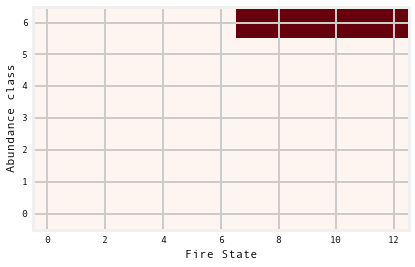

In [42]:
pl.imshow(np.array(sdp.policy[:, 0]).reshape(n_pop_classes, n_fire_classes), 
          aspect='auto', cmap='Reds', interpolation='nearest', origin='lower')
pl.ylabel('Abundance class'); pl.xlabel('Fire State');

---

## References

1. Chades I, Chapron G, Cros M-J, Garcia F & Sabbadin R (2014) 'MDPtoolbox: a multi-platform toolbox to solve stochastic dynamic programming problems', Ecography, vol. 37, no. 9, pp. 916–920, [doi 10.1111/ecog.00888](http://dx.doi.org/10.1111/ecog.00888).

2. Clark, CW and Mangel, M. Dynamic State Variable Models in Ecology: Methods and Applications, Oxford University Press, 2000.

3. Cordwell, SAW. [Optimal fire management of a threatened species, part 1](http://sawcordwell.github.io/mdp/conservation/2015/01/10/possingham1997-1/), Jan 10, 2015.

4.	Possingham H, Tuck G. Application of Stochastic Dynamic Programming to Optimal Fire Management of a Spatially Structured Threatened Species. In *Proceedings International Congress on Modelling and simulation*; 1997.

5.	Zipkin EF, Jennelle CS, Cooch EG. A primer on the application of Markov chains to the study of wildlife disease dynamics. Methods in Ecology and Evolution. 2010;1(2):192–198. doi:10.1111/j.2041-210X.2010.00018.x.